In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
f1_scorer = make_scorer(f1_score, average="macro")
from sklearn.metrics import roc_auc_score

from torch.optim import Adam
# becuase we're in a nested folder...
sys.path.append('../')

from utils_ellen.preprocess import *
from models.AEAD import AEAD

In [2]:
data_dir_v2 ="../for_students/data_v2"

In [3]:
def load_data(data_dir, window_size):
    '''
    data_dir (str): Base directory of data 
    window_size (str): Window size for input examples
    window_func (str): Window function reference as defined in utils.preprocess
                       Option are either 'window' or 'window_func'
    '''
    train_dir = os.path.join(data_dir, 'training')
    train_str = os.path.join(train_dir, 'training_{}.csv')
    test_str = os.path.join(data_dir, 'dataset_{}.csv')

    train_xs = []
    train_ys = []
    for i in [1, 2, 3, 4, 5, 100]: # file name updated to v2
        train_df_i = pd.read_csv(train_str.format(str(i)))
        
    # adding padded values and then windowing
        #         train_xi = window_func(train_df_i.kpi_value.values, window_size)
        local_min = train_df_i.kpi_value[0:window_size].min() # Using the global min as the padding 
        pad_min = np.ones(window_size) * local_min
        x_padded = np.concatenate([pad_min, train_df_i.kpi_value.values])
        train_xi = [x_padded[j:j+window_size] for j in range(len(x_padded)-(window_size))]
     
        train_xs.append(train_xi)
        train_ys.append(train_df_i.anomaly_label.values)
    x_train = np.concatenate(train_xs)
    y_train = np.concatenate(train_ys)
    assert len(x_train) == len(y_train)
    
    test_xs = []
    test_ys = []
    for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,100,101,102,103,105,106]:  # file name updated to v2
        test_df_i = pd.read_csv(test_str.format(str(i)))
#         test_xi = window_func(test_df_i.values[:,1], window_size)
        test_local_min = test_df_i.kpi_value.values[0:window_size].min() # Using the local min as the padding 
        test_pad_min = np.ones(window_size) * test_local_min
        test_x_padded = np.concatenate([test_pad_min, train_df_i.kpi_value.values])
        test_xi = [test_x_padded[j:j+window_size] for j in range(len(test_x_padded)-(window_size))]

    test_xs.append(test_xi)
    x_test = np.concatenate(test_xs)
    print("Train_x shape: {}\nTrain_y shape: {}\n\nTest_x shape: {}".format(x_train.shape, y_train.shape, x_test.shape))
    return x_train, y_train, x_test

def window_min_max(x):
    x_min = x.min(axis=1).reshape(-1, 1)
    x_max = x.max(axis=1).reshape(-1, 1)
    for i in range(len(x)):
        if x_max[i] > x_min[i]:
            x[i] =  (x[i] - x_min[i])/(x_max[i] - x_min[i])
        else:  # add scenario where x_max = x_min in a window 
            x[i] = 0
    return x

In [4]:
x_train, y_train, x_test = load_data(data_dir_v2, 100)

Train_x shape: (54337, 100)
Train_y shape: (54337,)

Test_x shape: (20159, 100)


In [5]:
# Window level normalisation
x_train = window_min_max(x_train)
x_test = window_min_max(x_test)

In [6]:
# Cross val incides
skf = StratifiedKFold(n_splits=5)

In [7]:
aead_aucs = []
for train_index, val_index in skf.split(x_train, y_train):
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    x_train_normal = x_train_fold[y_train_fold == 0]
    y_train_normal = y_train_fold[y_train_fold == 0]

    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    x_train_fold = window_min_max(x_train_fold)
    x_val_fold = window_min_max(x_val_fold)

#    aead = AEAD(100,256, 0.0001, 20, 'cpu', Adam).fit(x_train_normal,  y_train_normal)
#    y_pred_aead = aead.predict(x_val_fold)
#    val_auc = roc_auc_score(y_val_fold, y_pred_aead)
#    print(sum(y_val_fold ))
#    aead_aucs.append(val_auc)
#    print(val_auc)
#print(np.mean(aead_aucs))

In [8]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [9]:
#tf.get_logger().setLevel(40) # suppress deprecation messages
#tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs 
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

In [10]:
from tensorflow import keras

### LSTM Autoencoder --- From Keras 

See --- https://curiousily.com/posts/anomaly-detection-in-time-series-with-lstms-using-keras-in-python/#lstm-autoencoder-in-keras

In [11]:
x_train.shape

(54337, 100)

In [12]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)

In [13]:
x_train.shape

(54337, 100, 1)

In [16]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=x_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=x_train.shape[2])))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.1,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name="Adam")



model.compile(loss='mae', optimizer=optimizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 100, 64)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 64)           33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 64)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 1)            65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
__________________________________________________

In [17]:
history = model.fit(x_train, y_train, validation_split=.1,
    epochs=10, batch_size=128, shuffle=False)

Epoch 1/10
383/383 [==============================] - 50s 129ms/step - loss: 0.4931 - val_loss: 0.5123
Epoch 2/10
383/383 [==============================] - 58s 151ms/step - loss: 0.4801 - val_loss: 1.5865
Epoch 3/10
383/383 [==============================] - 59s 155ms/step - loss: 0.4239 - val_loss: 0.1166
Epoch 4/10
383/383 [==============================] - 60s 156ms/step - loss: 0.4207 - val_loss: 0.0501
Epoch 5/10
383/383 [==============================] - 60s 156ms/step - loss: 0.3899 - val_loss: 0.3495
Epoch 6/10
383/383 [==============================] - 60s 157ms/step - loss: 0.3380 - val_loss: 0.7487
Epoch 7/10
383/383 [==============================] - 61s 160ms/step - loss: 0.2994 - val_loss: 0.2315
Epoch 8/10
383/383 [==============================] - 60s 156ms/step - loss: 0.4663 - val_loss: 0.8913
Epoch 9/10
383/383 [==============================] - 58s 151ms/step - loss: 0.3813 - val_loss: 0.4226
Epoch 10/10
383/383 [==============================] - 56s 147ms/step - l

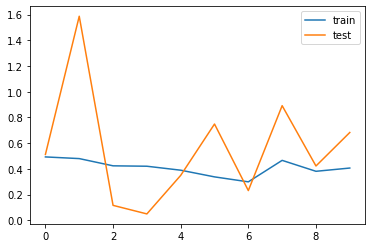

In [18]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [19]:
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

In [20]:
train_mae_loss

array([[0.66047306],
       [0.67007454],
       [0.67441808],
       ...,
       [1.32277131],
       [1.3279148 ],
       [1.33207908]])

In [21]:
import seaborn as sns

C:\Users\eoind\Anaconda3\envs\tensorflow-cpu\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


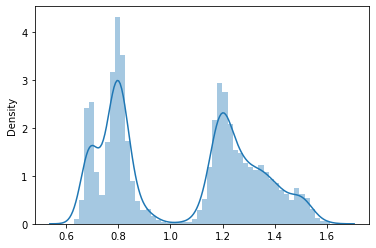

In [22]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [28]:
THRESHOLD = 1.5

df = pd.DataFrame(train_mae_loss)
df.columns=['loss']
df['label'] = y_train
df['threshold'] = THRESHOLD
df['anomaly'] = df.loss > df.threshold
anomalies = df[df.anomaly == True]


In [29]:
anomalies

,loss,label,threshold,anomaly
34280,1.500248,0,1.5,True
34281,1.501968,0,1.5,True
34282,1.503459,0,1.5,True
34283,1.503820,0,1.5,True
34284,1.505217,0,1.5,True
...,...,...,...,...
54261,1.514888,0,1.5,True
54262,1.517593,0,1.5,True
54263,1.519369,0,1.5,True
54264,1.511719,0,1.5,True


In [30]:
df[df.label==1]

,loss,label,threshold,anomaly
6922,0.691325,1,1.5,False
6923,0.684440,1,1.5,False
6924,0.683174,1,1.5,False
6925,0.694634,1,1.5,False
6926,0.716003,1,1.5,False
...,...,...,...,...
47572,1.452496,1,1.5,False
47573,1.454791,1,1.5,False
47574,1.438449,1,1.5,False
47575,1.437514,1,1.5,False
